In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as et 
import matplotlib.pyplot as plt

import time
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import en_core_web_sm
import nltk
from nltk import ne_chunk, pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
##### CREATE TRAIN DATAFRAME #####
l = []

xtree = et.parse("Laptop_Train.xml")
xroot = xtree.getroot()
for sentence in xroot.findall('sentence'):
    idi = sentence.get('id')
    text = sentence.find('text').text

    for neighbor in sentence.iter('aspectTerm'):
        # On mets 'id' et 'text' dans le dictionnaire avec toutes les variable qui nous intéresse
        neighbor.attrib['id'] = idi
        neighbor.attrib['text'] = text
        # on stock tous les dictionnaires crées dans une liste
        l.append(neighbor.attrib)
        
df_train = pd.DataFrame(l)
df_train.head(5)

,term,polarity,from,to,id,text
0,cord,neutral,41,45,2339,I charge it at night and skip taking the cord ...
1,battery life,positive,74,86,2339,I charge it at night and skip taking the cord ...
2,service center,negative,27,41,1316,The tech guy then said the service center does...
3,"""sales"" team",negative,109,121,1316,The tech guy then said the service center does...
4,tech guy,neutral,4,12,1316,The tech guy then said the service center does...


In [3]:
##### CREATE Test GOLD DATAFRAME #####
l = []

xtreeGoldTest = et.parse("Laptop_Test_Gold.xml")
xroot = xtreeGoldTest.getroot()
for sentence in xroot.findall('sentence'):
    idi = sentence.get('id')
    text = sentence.find('text').text
    
    #print(idi, text)
    for neighbor in sentence.iter('aspectTerm'):
        # On mets 'id' et 'text' dans le dictionnaire avec toutes les variable qui nous intéresse
        neighbor.attrib['id'] = idi
        neighbor.attrib['text'] = text
        # on stock tous les dictionnaires crées dans une liste
        l.append(neighbor.attrib)
df_testGold = pd.DataFrame(l)
df_testGold.head(5)

,term,polarity,from,to,id,text
0,aluminum body,positive,12,25,2128,I liked the aluminum body.
1,screen,positive,20,26,81,Lightweight and the screen is beautiful!
2,build quality,negative,9,22,353,"From the build quality to the performance, eve..."
3,performance,negative,30,41,353,"From the build quality to the performance, eve..."
4,costing,positive,30,37,655,It was truly a great computer costing less tha...


In [4]:
##### TOKENIZE & POS TAG du TRAIN #####
nlp = en_core_web_sm.load()

df_train['token_text'] = df_train.apply(lambda row: nlp(row["text"]), axis=1)

df_train

,term,polarity,from,to,id,text,token_text
0,cord,neutral,41,45,2339,I charge it at night and skip taking the cord ...,"(I, charge, it, at, night, and, skip, taking, ..."
1,battery life,positive,74,86,2339,I charge it at night and skip taking the cord ...,"(I, charge, it, at, night, and, skip, taking, ..."
2,service center,negative,27,41,1316,The tech guy then said the service center does...,"(The, tech, guy, then, said, the, service, cen..."
3,"""sales"" team",negative,109,121,1316,The tech guy then said the service center does...,"(The, tech, guy, then, said, the, service, cen..."
4,tech guy,neutral,4,12,1316,The tech guy then said the service center does...,"(The, tech, guy, then, said, the, service, cen..."
...,...,...,...,...,...,...,...
2353,Windows Server Enterprise 2003,neutral,104,134,2272,We also use Paralles so we can run virtual mac...,"(We, also, use, Paralles, so, we, can, run, vi..."
2354,Windows Server 2008 Enterprise,neutral,140,170,2272,We also use Paralles so we can run virtual mac...,"(We, also, use, Paralles, so, we, can, run, vi..."
2355,repair,conflict,24,30,848,"How Toshiba handles the repair seems to vary, ...","(How, Toshiba, handles, the, repair, seems, to..."
2356,repair,positive,130,136,848,"How Toshiba handles the repair seems to vary, ...","(How, Toshiba, handles, the, repair, seems, to..."


In [5]:
# on vérifie que les posTag ont bien été conservés
df_train.token_text[0]
[X.pos_ for X in  df_train.token_text[0]]

['PRON',
 'VERB',
 'PRON',
 'ADP',
 'NOUN',
 'CCONJ',
 'NOUN',
 'VERB',
 'DET',
 'NOUN',
 'ADP',
 'PRON',
 'SCONJ',
 'ADP',
 'DET',
 'ADJ',
 'NOUN',
 'NOUN',
 'PUNCT']

In [6]:
##### TOKENIZE & POS TAG TEST GOLD #####
df_testGold['token_text'] = df_testGold.apply(lambda row: nlp(row["text"]), axis=1)

df_testGold

,term,polarity,from,to,id,text,token_text
0,aluminum body,positive,12,25,2128,I liked the aluminum body.,"(I, liked, the, aluminum, body, .)"
1,screen,positive,20,26,81,Lightweight and the screen is beautiful!,"(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,negative,9,22,353,"From the build quality to the performance, eve...","(From, the, build, quality, to, the, performan..."
3,performance,negative,30,41,353,"From the build quality to the performance, eve...","(From, the, build, quality, to, the, performan..."
4,costing,positive,30,37,655,It was truly a great computer costing less tha...,"(It, was, truly, a, great, computer, costing, ..."
5,Boots up,positive,0,8,2443,Boots up fast and runs great!,"(Boots, up, fast, and, runs, great, !)"
6,runs,positive,18,22,2443,Boots up fast and runs great!,"(Boots, up, fast, and, runs, great, !)"
7,tech support,neutral,5,17,764,"Call tech support, standard email the form and...","(Call, tech, support, ,, standard, email, the,..."
8,service,positive,4,11,1479,The service I received from Toshiba went above...,"(The, service, I, received, from, Toshiba, wen..."
9,internet speed,positive,41,55,2937,I would recommend it just because of the inter...,"(I, would, recommend, it, just, because, of, t..."


In [7]:
#### Assigner la polarité de chaque mot et les ajouter dans les dataframes

df_train.insert(6,'Score_by_word',"")
df_testGold.insert(6,'Score_by_word',"")

df_train.insert(7,'Sentiword',"")
df_testGold.insert(7,'Sentiword',"")

df_testGold.head(4)

,term,polarity,from,to,id,text,Score_by_word,Sentiword,token_text
0,aluminum body,positive,12,25,2128,I liked the aluminum body.,,,"(I, liked, the, aluminum, body, .)"
1,screen,positive,20,26,81,Lightweight and the screen is beautiful!,,,"(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,negative,9,22,353,"From the build quality to the performance, eve...",,,"(From, the, build, quality, to, the, performan..."
3,performance,negative,30,41,353,"From the build quality to the performance, eve...",,,"(From, the, build, quality, to, the, performan..."


In [8]:
def penn_to_wn(tag):
  """
  Convertion des tags en simple WORDNET TAGS
  """
  if tag.startswith('J'):
    return wn.ADJ
  elif tag.startswith('N'):
    return wn.NOUN
  elif tag.startswith('R'):
    return wn.ADV
  elif tag.startswith('V'):
    return wn.VERB
  return None

lemmatizer = WordNetLemmatizer()


def get_sentiment(word,tag):
  """
  Return une liste de score positif negatif ou neutre et return une liste vide si le mot ne renvoie rien depuis senti wordnet.
  """
  wn_tag = penn_to_wn(tag)
  if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
    return []

  lemma = lemmatizer.lemmatize(word, pos=wn_tag)
  if not lemma:
    return []

  synsets = wn.synsets(word, pos=wn_tag)
  if not synsets:
    return []

  # Prend le premier sens du mot c'est à dire le sens le plus commun
  synset = synsets[0]
  swn_synset = swn.senti_synset(synset.name())

  return [swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

In [9]:
# On remplit nos colonnes vides, précémment crées
##### TRAIN DATAFRAME #####
ps = PorterStemmer()
i=0
for token in df_train.text :
    words_data= nltk.word_tokenize(str(token))
    tokens_without_sw = [word for word in words_data if not word in stopwords.words()]


    pos_val = nltk.pos_tag(tokens_without_sw)


    scores = []
    words_sentence = []

    for (x,y) in pos_val :
        scores.append(get_sentiment(x,y))
        words_sentence.append(x)

    df_train['Sentiword'][i] = words_sentence
    df_train['Score_by_word'][i] = scores
    i+=1

df_train.head(10)

,term,polarity,from,to,id,text,Score_by_word,Sentiword,token_text
0,cord,neutral,41,45,2339,I charge it at night and skip taking the cord ...,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...","[I, charge, night, skip, taking, cord, good, b...","(I, charge, it, at, night, and, skip, taking, ..."
1,battery life,positive,74,86,2339,I charge it at night and skip taking the cord ...,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...","[I, charge, night, skip, taking, cord, good, b...","(I, charge, it, at, night, and, skip, taking, ..."
2,service center,negative,27,41,1316,The tech guy then said the service center does...,"[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....","[The, tech, guy, said, service, center, 1-to-1...","(The, tech, guy, then, said, the, service, cen..."
3,"""sales"" team",negative,109,121,1316,The tech guy then said the service center does...,"[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....","[The, tech, guy, said, service, center, 1-to-1...","(The, tech, guy, then, said, the, service, cen..."
4,tech guy,neutral,4,12,1316,The tech guy then said the service center does...,"[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....","[The, tech, guy, said, service, center, 1-to-1...","(The, tech, guy, then, said, the, service, cen..."
5,quality,positive,14,21,2005,"it is of high quality, has a killer GUI, is ex...","[[0.125, 0.25, 0.625], [0.375, 0.0, 0.625], []...","[high, quality, ,, killer, GUI, ,, extremely, ...","(it, is, of, high, quality, ,, has, a, killer,..."
6,GUI,positive,36,39,2005,"it is of high quality, has a killer GUI, is ex...","[[0.125, 0.25, 0.625], [0.375, 0.0, 0.625], []...","[high, quality, ,, killer, GUI, ,, extremely, ...","(it, is, of, high, quality, ,, has, a, killer,..."
7,applications,positive,118,130,2005,"it is of high quality, has a killer GUI, is ex...","[[0.125, 0.25, 0.625], [0.375, 0.0, 0.625], []...","[high, quality, ,, killer, GUI, ,, extremely, ...","(it, is, of, high, quality, ,, has, a, killer,..."
8,use,positive,143,146,2005,"it is of high quality, has a killer GUI, is ex...","[[0.125, 0.25, 0.625], [0.375, 0.0, 0.625], []...","[high, quality, ,, killer, GUI, ,, extremely, ...","(it, is, of, high, quality, ,, has, a, killer,..."
9,start up,positive,8,16,2789,Easy to start up and does not overheat as much...,"[[0.625, 0.25, 0.125], [], [], [0.0, 0.0, 1.0]...","[Easy, start, overheat, much, laptops, .]","(Easy, to, start, up, and, does, not, overheat..."


In [10]:
# On remplit nos  colonnes vides, précémment crées
##### TEST GOLD DATAFRAME #####
ps = PorterStemmer()
i=0
for token in df_testGold.text :
    words_data= nltk.word_tokenize(str(token))
    tokens_without_sw = [word for word in words_data if not word in stopwords.words()]


    pos_val = nltk.pos_tag(tokens_without_sw)


    scores = []
    words_sentence = []

    for (x,y) in pos_val :
        scores.append(get_sentiment(x,y))
        words_sentence.append(x)

    df_testGold['Sentiword'][i] = words_sentence
    df_testGold['Score_by_word'][i] = scores
    i+=1

df_testGold.head(10)

,term,polarity,from,to,id,text,Score_by_word,Sentiword,token_text
0,aluminum body,positive,12,25,2128,I liked the aluminum body.,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], []]","[I, liked, aluminum, body, .]","(I, liked, the, aluminum, body, .)"
1,screen,positive,20,26,81,Lightweight and the screen is beautiful!,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], []]","[Lightweight, screen, beautiful, !]","(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,negative,9,22,353,"From the build quality to the performance, eve...","[[], [], [0.375, 0.0, 0.625], [0.125, 0.0, 0.8...","[From, build, quality, performance, ,, everyth...","(From, the, build, quality, to, the, performan..."
3,performance,negative,30,41,353,"From the build quality to the performance, eve...","[[], [], [0.375, 0.0, 0.625], [0.125, 0.0, 0.8...","[From, build, quality, performance, ,, everyth...","(From, the, build, quality, to, the, performan..."
4,costing,positive,30,37,655,It was truly a great computer costing less tha...,"[[], [0.625, 0.0, 0.375], [0.0, 0.0, 1.0], [0....","[It, truly, great, computer, costing, less, th...","(It, was, truly, a, great, computer, costing, ..."
5,Boots up,positive,0,8,2443,Boots up fast and runs great!,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0.0, 0...","[Boots, fast, runs, great, !]","(Boots, up, fast, and, runs, great, !)"
6,runs,positive,18,22,2443,Boots up fast and runs great!,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0.0, 0...","[Boots, fast, runs, great, !]","(Boots, up, fast, and, runs, great, !)"
7,tech support,neutral,5,17,764,"Call tech support, standard email the form and...","[[], [], [0.0, 0.0, 1.0], [], [0.375, 0.375, 0...","[Call, tech, support, ,, standard, email, form...","(Call, tech, support, ,, standard, email, the,..."
8,service,positive,4,11,1479,The service I received from Toshiba went above...,"[[], [0.0, 0.0, 1.0], [], [], [], [], [], [0.0...","[The, service, I, received, Toshiba, went, bey...","(The, service, I, received, from, Toshiba, wen..."
9,internet speed,positive,41,55,2937,I would recommend it just because of the inter...,"[[], [], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0],...","[I, would, recommend, internet, speed, probabl...","(I, would, recommend, it, just, because, of, t..."


In [11]:
df_train.insert(7,'PosTag',"")
df_testGold.insert(7,'PosTag',"")

df_testGold.head(3)

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,aluminum body,positive,12,25,2128,I liked the aluminum body.,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], []]",,"[I, liked, aluminum, body, .]","(I, liked, the, aluminum, body, .)"
1,screen,positive,20,26,81,Lightweight and the screen is beautiful!,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], []]",,"[Lightweight, screen, beautiful, !]","(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,negative,9,22,353,"From the build quality to the performance, eve...","[[], [], [0.375, 0.0, 0.625], [0.125, 0.0, 0.8...",,"[From, build, quality, performance, ,, everyth...","(From, the, build, quality, to, the, performan..."


In [12]:
for i in range(len(df_train.PosTag)):
    df_train['PosTag'][i] = [(X.pos_) for X in  df_train.token_text[i]]

for i in range(len(df_testGold.PosTag)):
    df_testGold['PosTag'][i] = [(X.pos_) for X in  df_testGold.token_text[i]]

In [13]:
df_train.head(3) 

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,cord,neutral,41,45,2339,I charge it at night and skip taking the cord ...,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...","[PRON, VERB, PRON, ADP, NOUN, CCONJ, NOUN, VER...","[I, charge, night, skip, taking, cord, good, b...","(I, charge, it, at, night, and, skip, taking, ..."
1,battery life,positive,74,86,2339,I charge it at night and skip taking the cord ...,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...","[PRON, VERB, PRON, ADP, NOUN, CCONJ, NOUN, VER...","[I, charge, night, skip, taking, cord, good, b...","(I, charge, it, at, night, and, skip, taking, ..."
2,service center,negative,27,41,1316,The tech guy then said the service center does...,"[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....","[DET, NOUN, NOUN, ADV, VERB, DET, NOUN, NOUN, ...","[The, tech, guy, said, service, center, 1-to-1...","(The, tech, guy, then, said, the, service, cen..."


In [14]:
df_testGold.head(3)

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,aluminum body,positive,12,25,2128,I liked the aluminum body.,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], []]","[PRON, VERB, DET, NOUN, NOUN, PUNCT]","[I, liked, aluminum, body, .]","(I, liked, the, aluminum, body, .)"
1,screen,positive,20,26,81,Lightweight and the screen is beautiful!,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], []]","[NOUN, CCONJ, DET, NOUN, AUX, ADJ, PUNCT]","[Lightweight, screen, beautiful, !]","(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,negative,9,22,353,"From the build quality to the performance, eve...","[[], [], [0.375, 0.0, 0.625], [0.125, 0.0, 0.8...","[ADP, DET, ADJ, NOUN, ADP, DET, NOUN, PUNCT, P...","[From, build, quality, performance, ,, everyth...","(From, the, build, quality, to, the, performan..."


In [15]:
##### TRAIN DATAFRAME #####
DF_train = df_train[['term','text','PosTag','Sentiword','Score_by_word','polarity','token_text']]
DF_train.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,cord,I charge it at night and skip taking the cord ...,"[PRON, VERB, PRON, ADP, NOUN, CCONJ, NOUN, VER...","[I, charge, night, skip, taking, cord, good, b...","[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...",neutral,"(I, charge, it, at, night, and, skip, taking, ..."
1,battery life,I charge it at night and skip taking the cord ...,"[PRON, VERB, PRON, ADP, NOUN, CCONJ, NOUN, VER...","[I, charge, night, skip, taking, cord, good, b...","[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...",positive,"(I, charge, it, at, night, and, skip, taking, ..."
2,service center,The tech guy then said the service center does...,"[DET, NOUN, NOUN, ADV, VERB, DET, NOUN, NOUN, ...","[The, tech, guy, said, service, center, 1-to-1...","[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....",negative,"(The, tech, guy, then, said, the, service, cen..."


In [16]:
##### TEST GOLD DATAFRAME #####
DF_test = df_testGold[['term','text','PosTag','Sentiword','Score_by_word','polarity','token_text']]
DF_test.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,aluminum body,I liked the aluminum body.,"[PRON, VERB, DET, NOUN, NOUN, PUNCT]","[I, liked, aluminum, body, .]","[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], []]",positive,"(I, liked, the, aluminum, body, .)"
1,screen,Lightweight and the screen is beautiful!,"[NOUN, CCONJ, DET, NOUN, AUX, ADJ, PUNCT]","[Lightweight, screen, beautiful, !]","[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], []]",positive,"(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,"From the build quality to the performance, eve...","[ADP, DET, ADJ, NOUN, ADP, DET, NOUN, PUNCT, P...","[From, build, quality, performance, ,, everyth...","[[], [], [0.375, 0.0, 0.625], [0.125, 0.0, 0.8...",negative,"(From, the, build, quality, to, the, performan..."


In [17]:
# Save en Dataframe grace à .pkl
df_train.to_pickle('df_train_PANDAS_DATAFRAME.pkl')  
df_testGold.to_pickle('df_test_PANDAS_DATAFRAME.pkl')

# Pour recharger les dataframes : 
df_train = pd.read_pickle('df_train_PANDAS_DATAFRAME.pkl')
df_testGold = pd.read_pickle('df_test_PANDAS_DATAFRAME.pkl')

df_train.head(3)

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,cord,neutral,41,45,2339,I charge it at night and skip taking the cord ...,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...","[PRON, VERB, PRON, ADP, NOUN, CCONJ, NOUN, VER...","[I, charge, night, skip, taking, cord, good, b...","(I, charge, it, at, night, and, skip, taking, ..."
1,battery life,positive,74,86,2339,I charge it at night and skip taking the cord ...,"[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...","[PRON, VERB, PRON, ADP, NOUN, CCONJ, NOUN, VER...","[I, charge, night, skip, taking, cord, good, b...","(I, charge, it, at, night, and, skip, taking, ..."
2,service center,negative,27,41,1316,The tech guy then said the service center does...,"[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....","[DET, NOUN, NOUN, ADV, VERB, DET, NOUN, NOUN, ...","[The, tech, guy, said, service, center, 1-to-1...","(The, tech, guy, then, said, the, service, cen..."


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(array([[460.,   0.,   0., 987.,   0.,   0., 866.,   0.,   0.,  45.],
        [  4.,   0.,   0.,  29.,   0.,   0.,  16.,   0.,   0.,   0.]]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 2 Lists of Patches objects>)

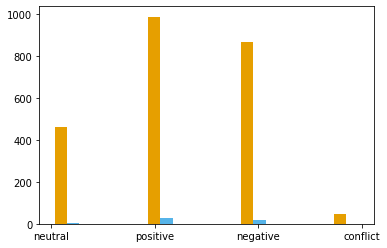

In [18]:
x1 = DF_train['polarity']
x2 = DF_test['polarity']

# On assigne une couleur unique (plus lisible sur le graphique)
colors = ['#E69F00', '#56B4E9']
names = ['TRAIN', 'TEST']
         

plt.hist([x1, x2],color = colors, label=names)

In [19]:
# NOMBRES
## TRAIN
posTrain=len(DF_train[DF_train['polarity'] == 'positive' ].index)
negTrain=len(DF_train[DF_train['polarity'] == 'negative' ].index)
neuTrain=len(DF_train[DF_train['polarity'] == 'neutral' ].index)
confTrain=len(DF_train[DF_train['polarity'] == 'conflict' ].index)

## TEST
posTest=len(DF_test[DF_test['polarity'] == 'positive' ].index)
negTest=len(DF_test[DF_test['polarity'] == 'negative' ].index)
neuTest=len(DF_test[DF_test['polarity'] == 'neutral' ].index)
confTest=len(DF_test[DF_test['polarity'] == 'conflict' ].index)

print("### TRAIN ###")
print("Nombre de positif : ",posTrain,", Nombre de negatif : ",negTrain,", Nombre de neutre : ",neuTrain,", Nombre de conflits : ",confTrain)
print("### TEST ###")
print("Nombre de positif : ",posTest,", Nombre de negatif : ",negTest,", Nombre de neutre : ",neuTest,", Nombre de conflits : ",confTest)

# TAUX
## TRAIN
pos_train=len(DF_train[DF_train['polarity'] == 'positive' ].index)/len(DF_train)*100
neg_train=len(DF_train[DF_train['polarity'] == 'negative' ].index)/len(DF_train)*100
neu_train=len(DF_train[DF_train['polarity'] == 'neutral' ].index)/len(DF_train)*100
conf_train=len(DF_train[DF_train['polarity'] == 'conflict' ].index)/len(DF_train)*100

## TEST
pos_test=len(DF_test[DF_test['polarity'] == 'positive' ].index)/len(DF_test)*100
neg_test=len(DF_test[DF_test['polarity'] == 'negative' ].index)/len(DF_test)*100
neu_test=len(DF_test[DF_test['polarity'] == 'neutral' ].index)/len(DF_test)*100
conf_test=len(DF_test[DF_test['polarity'] == 'conflict' ].index)/len(DF_test)*100

print("### TRAIN ###")
print("Positive : ",pos_train," %, Negative : ",neg_train," %, Neutral : ",neu_train," %, Conflicts : ",conf_train, " %")
print("### TEST ###")
print("Positive : ",pos_test," %, Negative : ",neg_test," %, Neutral : ",neu_test," %, Conflicts : ",conf_test, " %")

### TRAIN ###
Nombre de positif :  987 , Nombre de negatif :  866 , Nombre de neutre :  460 , Nombre de conflits :  45
### TEST ###
Nombre de positif :  29 , Nombre de negatif :  16 , Nombre de neutre :  4 , Nombre de conflits :  0
### TRAIN ###
Positive :  41.85750636132315  %, Negative :  36.72603901611535  %, Neutral :  19.508057675996607  %, Conflicts :  1.9083969465648856  %
### TEST ###
Positive :  59.183673469387756  %, Negative :  32.6530612244898  %, Neutral :  8.16326530612245  %, Conflicts :  0.0  %


Text(0.5, 1.0, 'Répartition en % des données en fonctions de leurs polarités ')

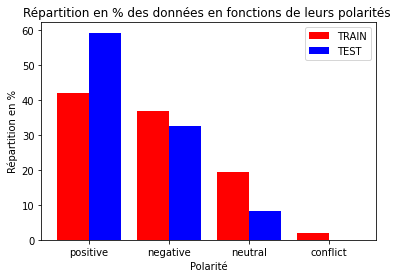

In [20]:
# Affichage au format Histogramme
barWidth = 0.4
train = [pos_train, neg_train, neu_train, conf_train]
test = [pos_test, neg_test, neu_test, conf_test]
r1 = range(len(train))
r2 = [x + barWidth for x in r1]

plotTrain= plt.bar(r1, train, width = barWidth, color = ['red' for i in train])
plotTest= plt.bar(r2, test, width = barWidth, color = ['blue' for i in train])
plt.xticks([r + barWidth / 2 for r in range(len(train))], ['positive', 'negative', 'neutral','conflict'])
plt.legend([plotTrain, plotTest], ['TRAIN', 'TEST'])
plt.xlabel("Polarité")
plt.ylabel("Répartition en %")
plt.title("Répartition en % des données en fonctions de leurs polarités ")

In [21]:
# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_train[DF_train['polarity'] == 'conflict' ].index
# on retire les lignes concernées
DF_train.drop(indexNames , inplace=True)

# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_test[DF_test['polarity'] == 'conflict' ].index
# on retire les lignes concernées
DF_test.drop(indexNames , inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_train[DF_train['polarity'] == 'conflict' ].index

# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_test[DF_test['polarity'] == 'conflict' ].index

In [23]:
# Save 
DF_train.to_pickle('DF_train_PANDAS_DATAFRAME.pkl')  
DF_test.to_pickle('DF_test_PANDAS_DATAFRAME.pkl')  

#Pour recharger les dataframe : 
DF_train = pd.read_pickle('DF_train_PANDAS_DATAFRAME.pkl')
DF_test = pd.read_pickle('DF_test_PANDAS_DATAFRAME.pkl')

In [24]:
DF_train.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,cord,I charge it at night and skip taking the cord ...,"[PRON, VERB, PRON, ADP, NOUN, CCONJ, NOUN, VER...","[I, charge, night, skip, taking, cord, good, b...","[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...",neutral,"(I, charge, it, at, night, and, skip, taking, ..."
1,battery life,I charge it at night and skip taking the cord ...,"[PRON, VERB, PRON, ADP, NOUN, CCONJ, NOUN, VER...","[I, charge, night, skip, taking, cord, good, b...","[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...",positive,"(I, charge, it, at, night, and, skip, taking, ..."
2,service center,The tech guy then said the service center does...,"[DET, NOUN, NOUN, ADV, VERB, DET, NOUN, NOUN, ...","[The, tech, guy, said, service, center, 1-to-1...","[[], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], [0....",negative,"(The, tech, guy, then, said, the, service, cen..."


In [25]:
DF_test.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,aluminum body,I liked the aluminum body.,"[PRON, VERB, DET, NOUN, NOUN, PUNCT]","[I, liked, aluminum, body, .]","[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], []]",positive,"(I, liked, the, aluminum, body, .)"
1,screen,Lightweight and the screen is beautiful!,"[NOUN, CCONJ, DET, NOUN, AUX, ADJ, PUNCT]","[Lightweight, screen, beautiful, !]","[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [], []]",positive,"(Lightweight, and, the, screen, is, beautiful, !)"
2,build quality,"From the build quality to the performance, eve...","[ADP, DET, ADJ, NOUN, ADP, DET, NOUN, PUNCT, P...","[From, build, quality, performance, ,, everyth...","[[], [], [0.375, 0.0, 0.625], [0.125, 0.0, 0.8...",negative,"(From, the, build, quality, to, the, performan..."


In [26]:
print("DataFrame after reset_index:")
DF_train.reset_index(inplace=True, drop=False)

DataFrame after reset_index:


In [27]:
# TRAIN DATASET
df_train = DF_train

list_train = []
label_train = []
print(df_train)
for i in range(len(df_train)):
    pos_tag = [X.pos_ for X in  df_train.token_text[i]]
    pos_tag_text = " ".join(pos_tag)
    senti_word = " ".join(df_train.Sentiword[i])
    score_by_word = ",".join(str(v) for v in df_train.Score_by_word[i])
    
    list_train.append(
        (df_train.term[i],
        df_train.text[i],
        pos_tag_text,
        senti_word,
        score_by_word,
        ))
    label_train.append(df_train.polarity[i])

list_train

Laptop_Train = np.array(list_train)
print(Laptop_Train)


      index  ...                                         token_text
0         0  ...  (I, charge, it, at, night, and, skip, taking, ...
1         1  ...  (I, charge, it, at, night, and, skip, taking, ...
2         2  ...  (The, tech, guy, then, said, the, service, cen...
3         3  ...  (The, tech, guy, then, said, the, service, cen...
4         4  ...  (The, tech, guy, then, said, the, service, cen...
...     ...  ...                                                ...
2308   2352  ...  (We, also, use, Paralles, so, we, can, run, vi...
2309   2353  ...  (We, also, use, Paralles, so, we, can, run, vi...
2310   2354  ...  (We, also, use, Paralles, so, we, can, run, vi...
2311   2356  ...  (How, Toshiba, handles, the, repair, seems, to...
2312   2357  ...  (I, would, like, to, use, a, different, operat...

[2313 rows x 8 columns]
[['cord'
  'I charge it at night and skip taking the cord with me because of the good battery life.'
  'PRON VERB PRON ADP NOUN CCONJ NOUN VERB DET NOUN ADP PR

In [28]:
# TEST GOLD DATASET
df_test = DF_test

list_test = []
label_test = []

for i in range(len(df_test)):
    pos_tag = [X.pos_ for X in  df_test.token_text[i]]
    pos_tag_text = " ".join(pos_tag)
    senti_word = " ".join(df_test.Sentiword[i])
    score_by_word = ",".join(str(v) for v in df_test.Score_by_word[i])
    
    list_test.append(
        (df_test.term[i],
        df_test.text[i],
        pos_tag_text,
        senti_word,
        score_by_word,
        ))
    label_test.append(df_test.polarity[i])


import numpy as np
Laptop_Test = np.array(list_test)
print(Laptop_Test)


[['aluminum body' 'I liked the aluminum body.'
  'PRON VERB DET NOUN NOUN PUNCT' 'I liked aluminum body .'
  '[],[],[0.0, 0.0, 1.0],[0.0, 0.0, 1.0],[]']
 ['screen' 'Lightweight and the screen is beautiful!'
  'NOUN CCONJ DET NOUN AUX ADJ PUNCT' 'Lightweight screen beautiful !'
  '[0.0, 0.0, 1.0],[0.0, 0.0, 1.0],[],[]']
 ['build quality'
  'From the build quality to the performance, everything about it has been sub-par from what I would have expected from Apple.'
  'ADP DET ADJ NOUN ADP DET NOUN PUNCT PRON ADP PRON AUX AUX ADJ ADJ ADJ ADP PRON PRON VERB AUX VERB ADP PROPN PUNCT'
  'From build quality performance , everything sub-par I would expected Apple .'
  '[],[],[0.375, 0.0, 0.625],[0.125, 0.0, 0.875],[],[],[],[],[],[],[0.0, 0.0, 1.0],[]']
 ['performance'
  'From the build quality to the performance, everything about it has been sub-par from what I would have expected from Apple.'
  'ADP DET ADJ NOUN ADP DET NOUN PUNCT PRON ADP PRON AUX AUX ADJ ADJ ADJ ADP PRON PRON VERB AUX VERB A

In [29]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform(DF_train['text'])
test_vectors = vectorizer.transform(DF_test['text'])

# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(train_vectors, DF_train['polarity'])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

# Resultats
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(DF_test['polarity'], prediction_linear, output_dict=True)


print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])

Training time: 0.734414s; Prediction time: 0.011676s
positive:  {'precision': 0.8620689655172413, 'recall': 0.8620689655172413, 'f1-score': 0.8620689655172413, 'support': 29}
negative:  {'precision': 0.75, 'recall': 0.75, 'f1-score': 0.75, 'support': 16}
neutral:  {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 4}


In [30]:
### TEST ###
L = len(Laptop_Test)
X_test = []
y_test = []
for i in range(0,L):
    X_test.append(Laptop_Test[i][0] + " " + Laptop_Test[i][1] + " " + Laptop_Test[i][2] + " " + Laptop_Test[i][3]+ " " + Laptop_Test[i][4])
    y_test.append(label_test[i])

X_test[0:3]

['aluminum body I liked the aluminum body. PRON VERB DET NOUN NOUN PUNCT I liked aluminum body . [],[],[0.0, 0.0, 1.0],[0.0, 0.0, 1.0],[]',
 'screen Lightweight and the screen is beautiful! NOUN CCONJ DET NOUN AUX ADJ PUNCT Lightweight screen beautiful ! [0.0, 0.0, 1.0],[0.0, 0.0, 1.0],[],[]',
 'build quality From the build quality to the performance, everything about it has been sub-par from what I would have expected from Apple. ADP DET ADJ NOUN ADP DET NOUN PUNCT PRON ADP PRON AUX AUX ADJ ADJ ADJ ADP PRON PRON VERB AUX VERB ADP PROPN PUNCT From build quality performance , everything sub-par I would expected Apple . [],[],[0.375, 0.0, 0.625],[0.125, 0.0, 0.875],[],[],[],[],[],[],[0.0, 0.0, 1.0],[]']

In [31]:
### TRAIN ###

L = len(Laptop_Train)
X_train = []
y_train = []
for i in range(0,L):
    X_train.append(Laptop_Train[i][0] + " " + Laptop_Train[i][1] + " " + Laptop_Train[i][2] + " " + Laptop_Train[i][3]+ " " + Laptop_Train[i][4])
    y_train.append(label_train[i])

X_train[0:3]

['cord I charge it at night and skip taking the cord with me because of the good battery life. PRON VERB PRON ADP NOUN CCONJ NOUN VERB DET NOUN ADP PRON SCONJ ADP DET ADJ NOUN NOUN PUNCT I charge night skip taking cord good battery life . [],[],[0.0, 0.0, 1.0],[0.0, 0.0, 1.0],[],[0.0, 0.0, 1.0],[0.75, 0.0, 0.25],[0.0, 0.0, 1.0],[0.0, 0.0, 1.0],[]',
 'battery life I charge it at night and skip taking the cord with me because of the good battery life. PRON VERB PRON ADP NOUN CCONJ NOUN VERB DET NOUN ADP PRON SCONJ ADP DET ADJ NOUN NOUN PUNCT I charge night skip taking cord good battery life . [],[],[0.0, 0.0, 1.0],[0.0, 0.0, 1.0],[],[0.0, 0.0, 1.0],[0.75, 0.0, 0.25],[0.0, 0.0, 1.0],[0.0, 0.0, 1.0],[]',
 'service center The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the "sales" team, which is the retail shop which I bought my netbook from. DET NOUN NOUN ADV VERB DET NOUN NOUN AUX PART AUX PROPN NOUN CCONJ PRON AUX PART VERB DET NOU

In [32]:
# Creation des vecteurs
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)

X_train_tf = tf_transformer.transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)
X_test_tf = tf_transformer.transform(X_test_counts)

print(X_train_counts.shape)
print(X_train_tf.shape)

print(X_test_counts.shape)
print(X_test_tf.shape)

(2313, 3079)
(2313, 3079)
(49, 3079)
(49, 3079)


In [34]:
# Test avec kernel=rbf
classifier_linear = svm.SVC(kernel='rbf')
t0 = time.time()
classifier_linear.fit(X_train_tf, y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(X_test_tf)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

# Resultats
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, output_dict=True)

print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])
print('\n------ REPORT ------')
report

Training time: 1.538238s; Prediction time: 0.023651s
positive:  {'precision': 0.8387096774193549, 'recall': 0.896551724137931, 'f1-score': 0.8666666666666666, 'support': 29}
negative:  {'precision': 0.8125, 'recall': 0.8125, 'f1-score': 0.8125, 'support': 16}
neutral:  {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 4}

------ REPORT ------


{'accuracy': 0.8367346938775511,
 'macro avg': {'f1-score': 0.7819444444444444,
  'precision': 0.883736559139785,
  'recall': 0.7363505747126436,
  'support': 49},
 'negative': {'f1-score': 0.8125,
  'precision': 0.8125,
  'recall': 0.8125,
  'support': 16},
 'neutral': {'f1-score': 0.6666666666666666,
  'precision': 1.0,
  'recall': 0.5,
  'support': 4},
 'positive': {'f1-score': 0.8666666666666666,
  'precision': 0.8387096774193549,
  'recall': 0.896551724137931,
  'support': 29},
 'weighted avg': {'f1-score': 0.8326530612244898,
  'precision': 0.8433179723502305,
  'recall': 0.8367346938775511,
  'support': 49}}

In [35]:
# Test avec kernel=poly
classifier_linear = svm.SVC(kernel='poly')
t0 = time.time()
classifier_linear.fit(X_train_tf, y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(X_test_tf)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

# Resultats
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, output_dict=True)

print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])
print('\n------ REPORT ------')
report

Training time: 1.546931s; Prediction time: 0.023770s
positive:  {'precision': 0.9354838709677419, 'recall': 1.0, 'f1-score': 0.9666666666666666, 'support': 29}
negative:  {'precision': 1.0, 'recall': 0.9375, 'f1-score': 0.967741935483871, 'support': 16}
neutral:  {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 4}

------ REPORT ------


{'accuracy': 0.9591836734693877,
 'macro avg': {'f1-score': 0.9305171530977981,
  'precision': 0.978494623655914,
  'recall': 0.8958333333333334,
  'support': 49},
 'negative': {'f1-score': 0.967741935483871,
  'precision': 1.0,
  'recall': 0.9375,
  'support': 16},
 'neutral': {'f1-score': 0.8571428571428571,
  'precision': 1.0,
  'recall': 0.75,
  'support': 4},
 'positive': {'f1-score': 0.9666666666666666,
  'precision': 0.9354838709677419,
  'recall': 1.0,
  'support': 29},
 'weighted avg': {'f1-score': 0.9580770557070755,
  'precision': 0.9618169848584595,
  'recall': 0.9591836734693877,
  'support': 49}}